# SKLEARN "Diabetes" DATASET - Machine Learning Model Prediction

<p>&nbsp;</p>
<p>&nbsp;</p>

In [1]:
from IPython.display import display, HTML
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error as MAE, r2_score
sns.set()

## Dataset Load & Exploratory Analysis

Il Dataset verrà utilizzato per prevedere il progresso del diabete nei casi studio in base hai valori registrati nell'arco di un anno:

- Le misurazioni rilevate dai pazienti sono:
    - __Età__
    - __Sesso__
    - __BMI__: Indice di massa corporea
    - __BP__: Pressione sanguigna media
    - __S1__: misurazione totale del colesterolo nel sangue
    - __S2__: misurazione delle lipoproteine a bassa densità nel sangue
    - __S3__: misurazione delle lipoproteine ad alta densità nel sangue
    - __S4__: HDL/misurazione sierica del colesterolo totale
    - __S5__: misurazione dei trigliceridi nel sangue
    - __S6__: indice glicemico
<p>&nbsp;</p>

- I valori di progressione della malattia sono stati registrati attraverso un indice rappresentato da una variabile continua; per questo i modelli predittivi utilizzati faranno riferimento al criterio della regressione.

In [2]:
# caricamento e trasformazione del dataset "diabetes" attraverso il formato Data Frame di pandas
diabetes = datasets.load_diabetes(as_frame=True,scaled=False)
df_diab = pd.DataFrame(columns=diabetes.feature_names,data=diabetes.data)

#inserimento della colonna target
df_diab.insert(0,'diab_rate',diabetes.target.astype(int))

# le colonne vengono rinominate per una maggiore comprensione delle misurazioni
df_diab = df_diab.rename(columns={'bmi':'body_mass','bp':'av_blood_pressure','s1':'serum_cholesterol',
                                  's2':'low_lipoproteins','s3':'high_lipoproteins','s4':'cholesterol',
                                  's5':'serum_triglycerides_level','s6':'blood_sugar_level'})
# visualizzazione del dataset
df_diab

,diab_rate,age,sex,body_mass,av_blood_pressure,serum_cholesterol,low_lipoproteins,high_lipoproteins,cholesterol,serum_triglycerides_level,blood_sugar_level
0,151,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0
1,75,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0
2,141,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0
3,206,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0
4,135,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0
...,...,...,...,...,...,...,...,...,...,...,...
437,178,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0
438,104,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0
439,132,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0
440,220,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0


Il dataset non contiene valori nulli da gestire.

In [3]:
df_diab.isnull().any()

diab_rate                    False
age                          False
sex                          False
body_mass                    False
av_blood_pressure            False
serum_cholesterol            False
low_lipoproteins             False
high_lipoproteins            False
cholesterol                  False
serum_triglycerides_level    False
blood_sugar_level            False
dtype: bool

Nel verificare la correlazione lineare tra tutte le variabili del dataset si può notare che alcune features, come "__low_lipoproteins__" e "__serum_cholesterol__", presentano un'elevata correlazione.

Per questo saranno svolti successivamente dei test con la Features Selection per testare l'importanza o la ridondanza delle features presenti nel dataset.

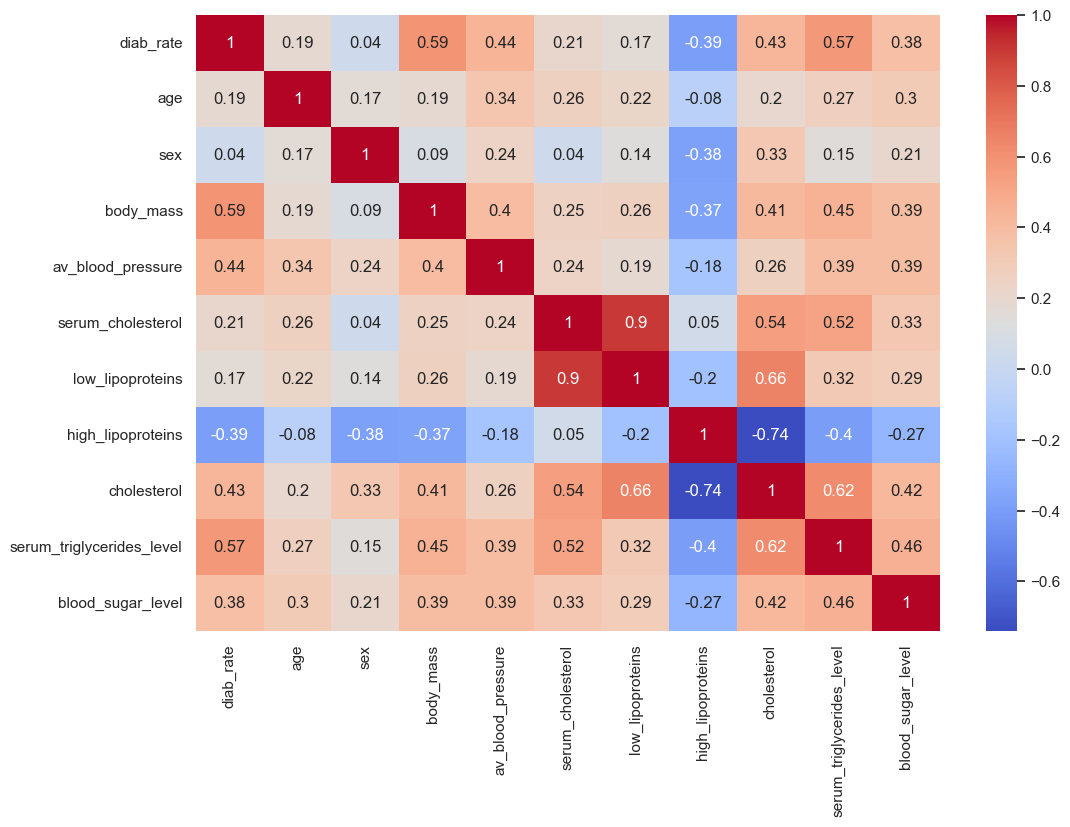

In [4]:
# heatmap sulle correlazioni tra ogni variabile presente nel dataset diabetes
plt.figure(figsize=(12, 8))
sns.heatmap(round(df_diab.corr(),2),annot=True,cmap='coolwarm')
plt.show()

### Target

La frequenza della variabile target "__diab_rate__" mostra una distribuzione asimmetrica, con picchi tra 50 e 200 nell'indice di progressione della malattia.

Ad una prima analisi, data la natura non normale della distribuzione del target, i modelli più adatti per la sua previsione potrebbero essere di __tipo non parametrico__, di modo da adattarsi meglio alla natura dei dati e catturare in maniera più efficiente le relazioni non lineari presenti.

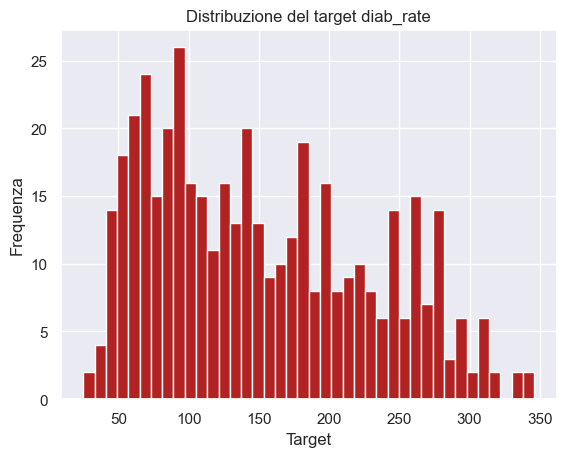

In [5]:
# visualizzazione con istogramma della distribuzione dei valori della variabile target
df_diab['diab_rate'].hist(bins=40,color='firebrick')
plt.title("Distribuzione del target diab_rate")
plt.xlabel('Target')
plt.ylabel('Frequenza')
plt.show()

### Features

Il dataset presenta 2 tipi di features: 

- __Numeriche-continue__
    - age                   
    - body_mass                    
    - av_blood_pressure           
    - serum_cholesterol          
    - low_lipoproteins             
    - high_lipoproteins            
    - cholesterol                  
    - serum_triglycerides_level    
    - blood_sugar_level           

<p>&nbsp;</p>

- __Numeriche-discrete__
    - sex

<p>&nbsp;</p>


La maggior parte delle distribuzioni delle features continue mostra una somiglianza con la curva gaussiana.

Il rapporto delle features continue con la variabile target mostra una buona capacità predittiva delle variabili:

- __body_mass__
- __serum_triglycerides_level__
- __av_blood_pressure__
- __cholesterol__
- __blood_sugar_level__

Inoltre si nota che la variabile __cholesterol__ presenta un distribuzione di valori molto simile ad una variabile discreta, probabilmente dovuta ad un arrotondamento dei dati; data la già significativa relazione della feature con la variabile target non si procederà a trasformarla ulteriormente.

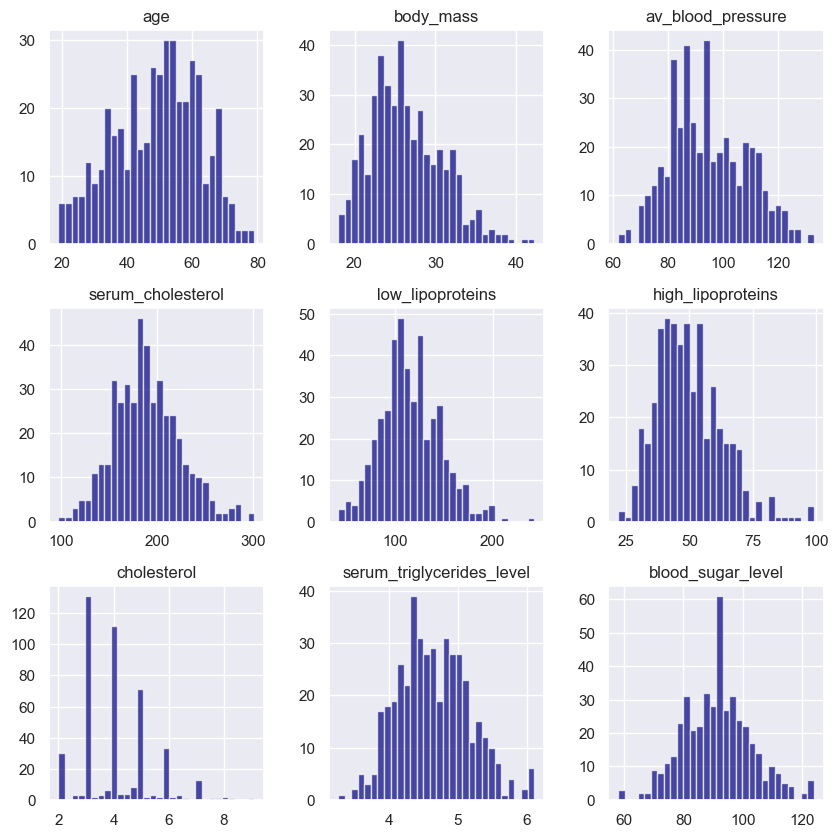

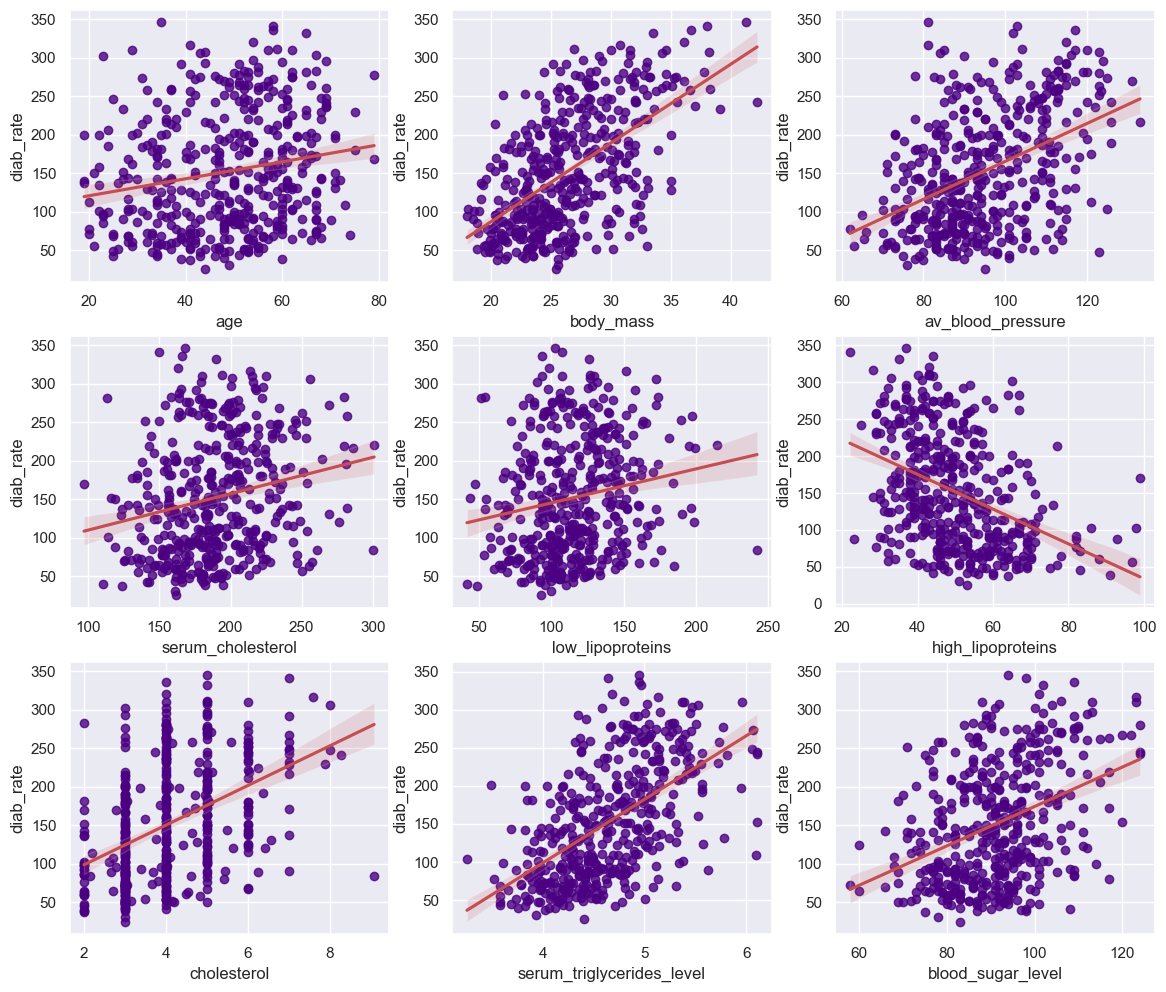

In [6]:
# istogramma per la rappresentazione della distribuzione delle variabili continue
df_diab.drop(columns=['sex','diab_rate']).hist(figsize=(10, 10), bins=30,color='navy',alpha=0.7)

#creazione degli assi da iterare per la visualizzazione dei grafici
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(14,12))

# ciclo for per visualizzare i grafici di correlazione tra le features continue ed il target
for n,features in enumerate(df_diab.drop(columns='sex').columns[1:]):
    ax=axes.flat[n]
    sns.regplot(data=df_diab,x=features,y=df_diab.diab_rate,ax=ax,color='indigo',line_kws=dict(color='r'))

La feature numerica discreta "__sex__" mostra una presenza di campioni ed una frequenza bilanciati tra uomini e donne.

Inoltre si nota che nel rapporto con le feature "__high_lipoproteins__", "__cholesterol__" e "__av_blood_pressure__", la variabile "__sex__" riscontra una discreta influenza nella relazione tra le features con la variabile target, dimostrando che il loro rapporto può variare a seconda del genere ed essere rilevante al livello predittivo.

   sex  count
0  1.0    235
1  2.0    207


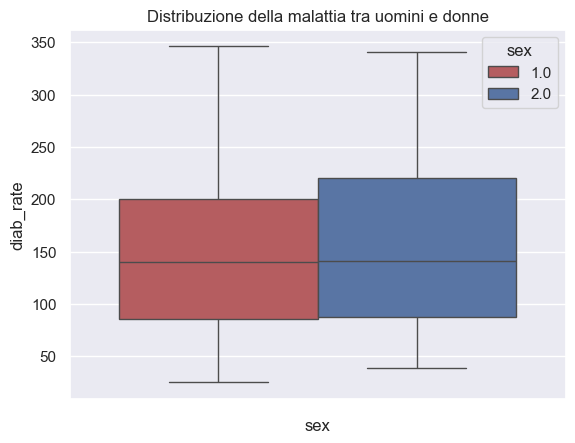

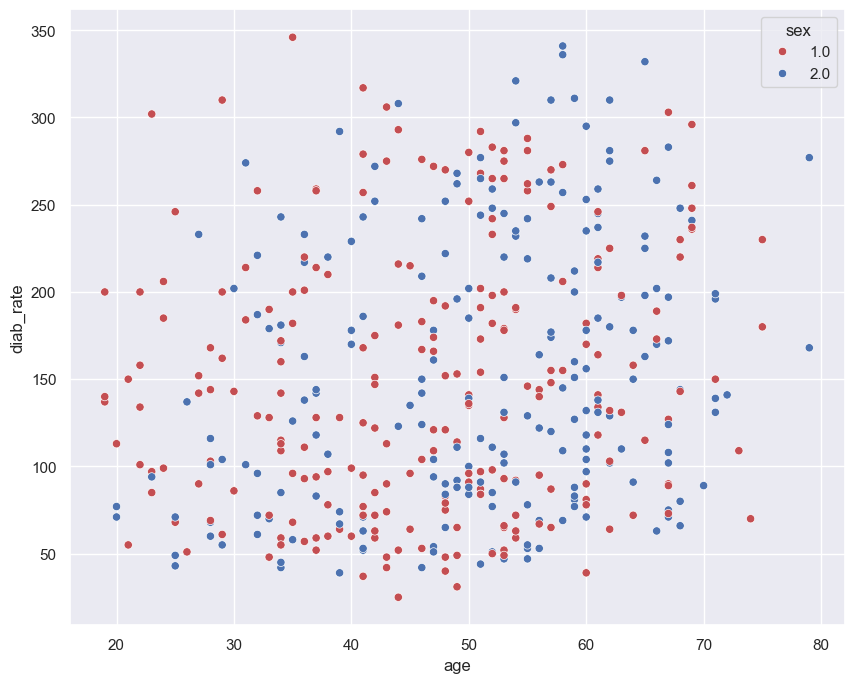

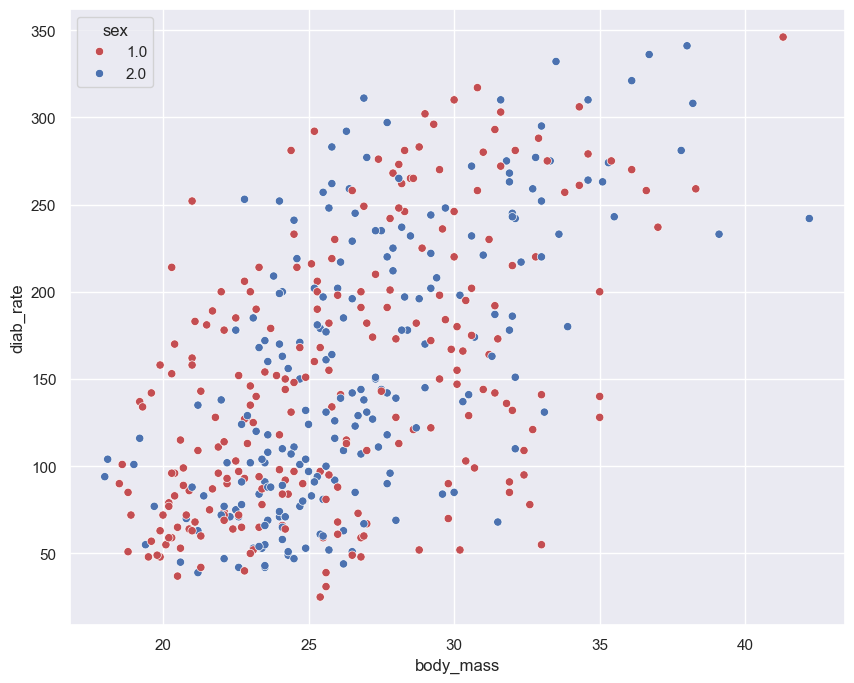

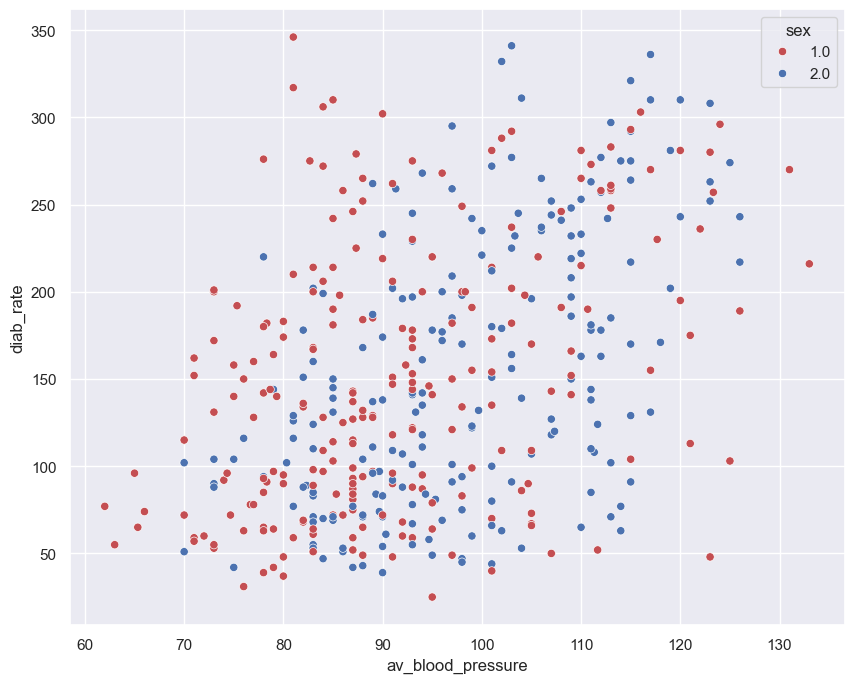

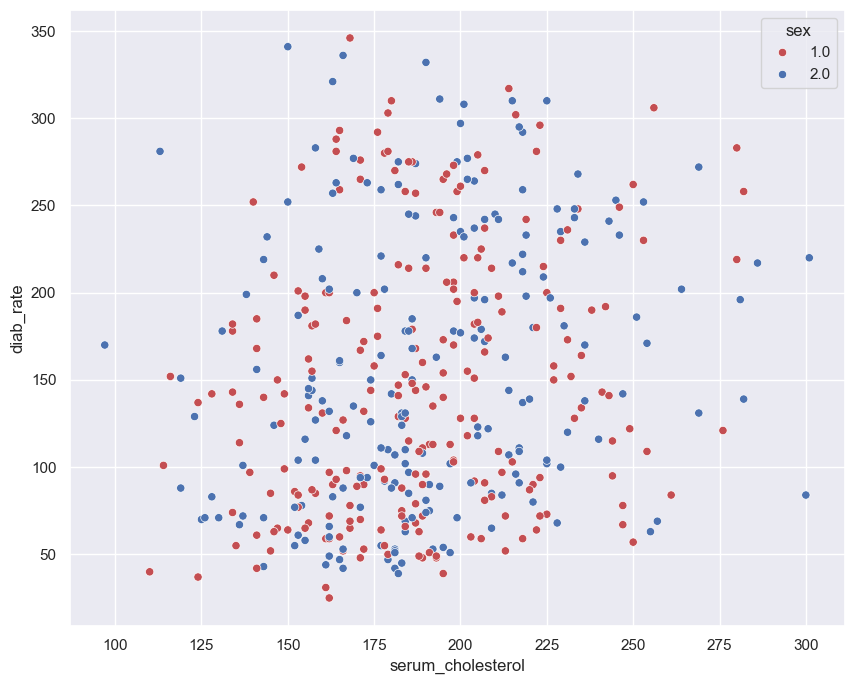

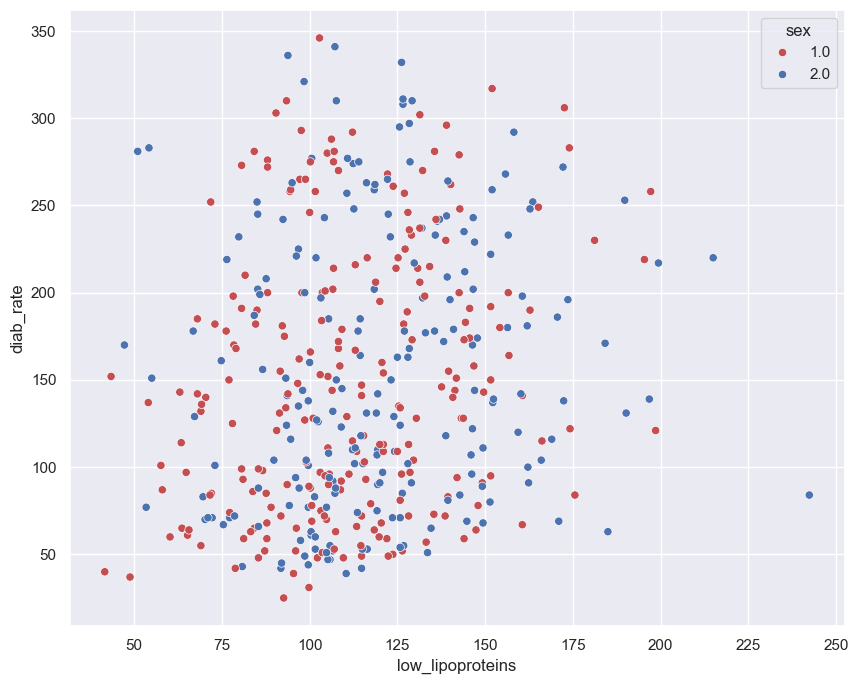

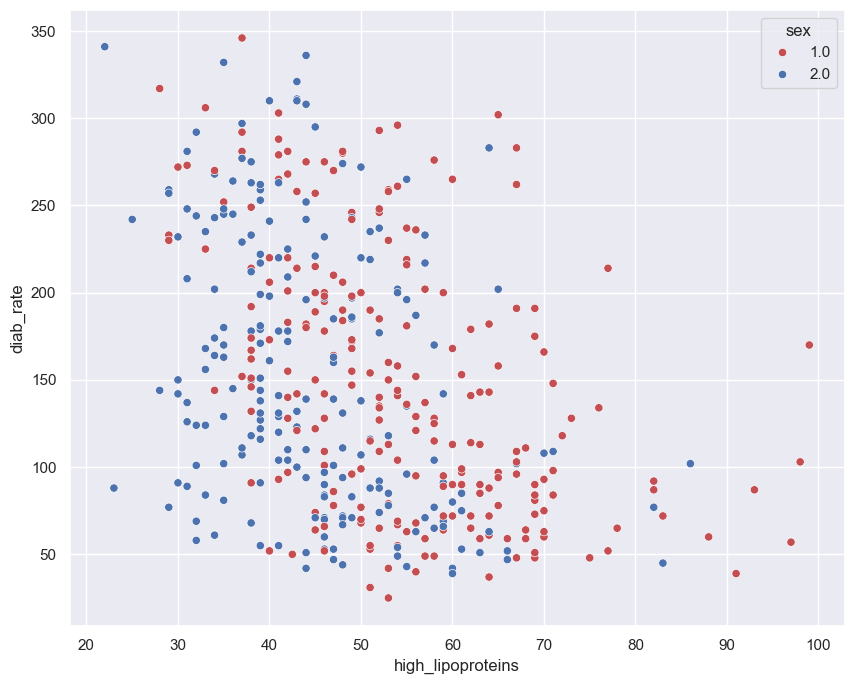

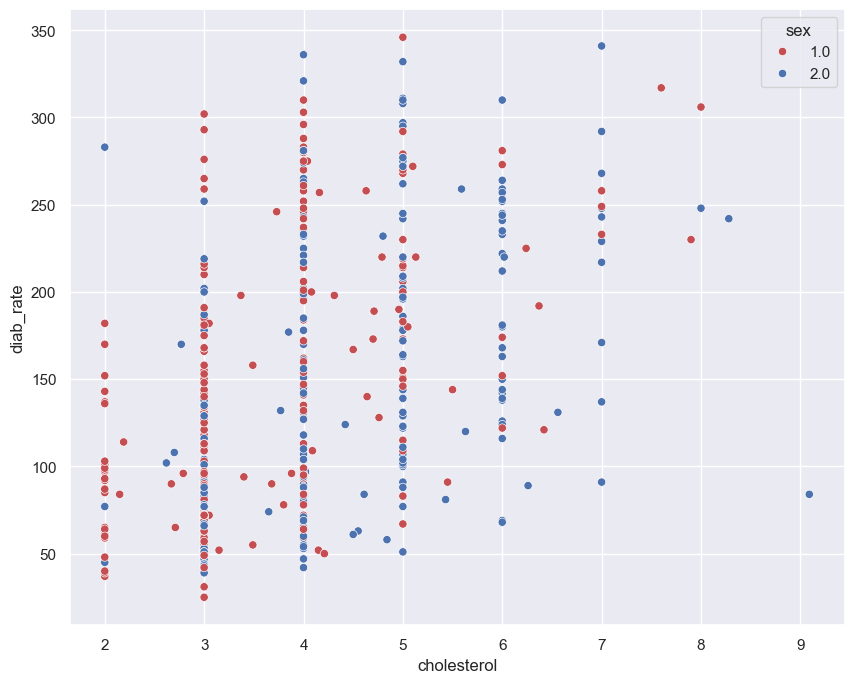

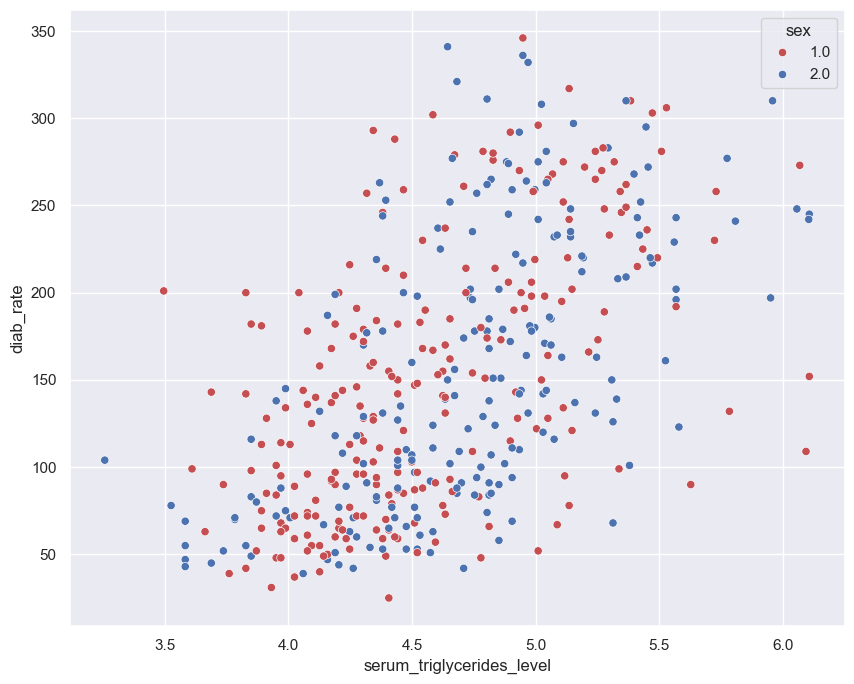

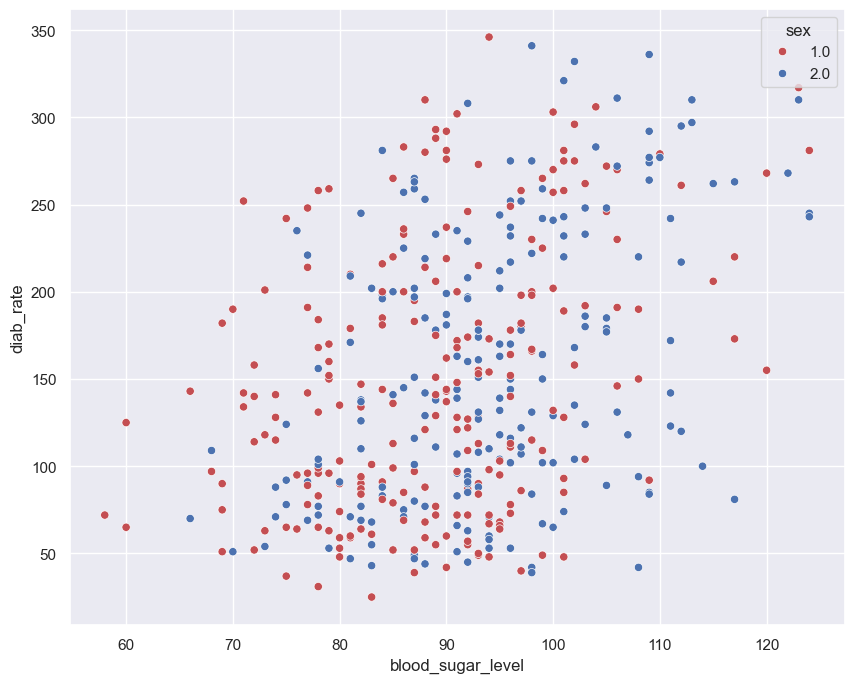

In [7]:
# visualizzazione del conteggio dei campioni per la variabile sex
print(df_diab.sex.value_counts().reset_index())

# boxplot per la visualizzazione della distribuzione della variabile sex rispetto al target diab_rate
sns.boxplot(data=df_diab,y='diab_rate',hue='sex',palette=['r','b'])
plt.title("Distribuzione della malattia tra uomini e donne")
plt.xlabel("sex")
plt.ylabel("diab_rate")
plt.show()

# visualizzazione tramite scatterplot dell'influenza della variabile sex nella relazione tra il target ed ogni feature
for feature in df_diab.drop(columns=['diab_rate','sex']).columns:
    plt.figure(figsize=(10,8))
    sns.scatterplot(x=df_diab[f'{feature}'], y=df_diab.diab_rate, hue=df_diab.sex, palette=['r','b'])

<p>&nbsp;</p>

### Outliers Detection

Gli outliers presenti nel dataset non influiscono sulle predizioni, in quanto la loro presenza è molto ridotta rispetto al totale dei casi.

Di conseguenza i dati saranno scalati attraverso la funzione __StandardScaler()__ e le metriche utilizzate per valutare i modelli saranno l'indice di determinazione __R2__ e il __Mean Absolute Error__ con lo scopo di:
- ottimizzare la capacità predittiva dei modelli, verificandone le predizioni rispetto ai valori reali del test set
- attuare un calcolo dell'errore medio meno sensibile agli outliers e più focalizzato sui valori in prossimità della mediana

In [8]:
# dizionario per la raccolta dei nomi delle features e del conteggio degli outliers
outliers_dict = {}

# ciclo for per iterare i nomi delle colonne delle features senza il target
for column in df_diab.drop(columns=['sex','diab_rate']).columns:

# divisione in primo e terzo quantile per ogni colonna del dataset
    q25,q75 = df_diab[column].quantile(0.25), df_diab[column].quantile(0.75)

# calcolo dell'Interquantile Range per definire la soglia superiore ed inferiore secondo cui identificare gli outliers
    IQR = q75-q25

# calcolo delle soglie
    low_bound,up_bound = q25-1.5*IQR, q75+1.5*IQR

# identificazione dei valori outlier nel dataset ed inserimento nel dizionario precedentemente creato
    outliers = df_diab.iloc[:,1:][(df_diab[column] < low_bound)|(df_diab[column] > up_bound)]
    outliers_dict[column]=outliers.shape[0]

# dizionario per la creazione di un Data Frame con i dati riscontrati
frame = {'features':pd.Series(outliers_dict.keys()),
         'outliers_count':pd.Series(outliers_dict.values())}
outliers_frame = pd.DataFrame(frame)

# creazione della colonna con le percentuali degli outliers sul totale dei casi per colonna e visualizzazione
outliers_frame['percentage'] = round(((outliers_frame.outliers_count/df_diab.shape[0])*100),2)
outliers_frame

,features,outliers_count,percentage
0,age,0,0.00
1,body_mass,3,0.68
2,av_blood_pressure,0,0.00
3,serum_cholesterol,8,1.81
4,low_lipoproteins,7,1.58
5,high_lipoproteins,7,1.58
6,cholesterol,2,0.45
7,serum_triglycerides_level,4,0.90
8,blood_sugar_level,9,2.04


<Axes: >

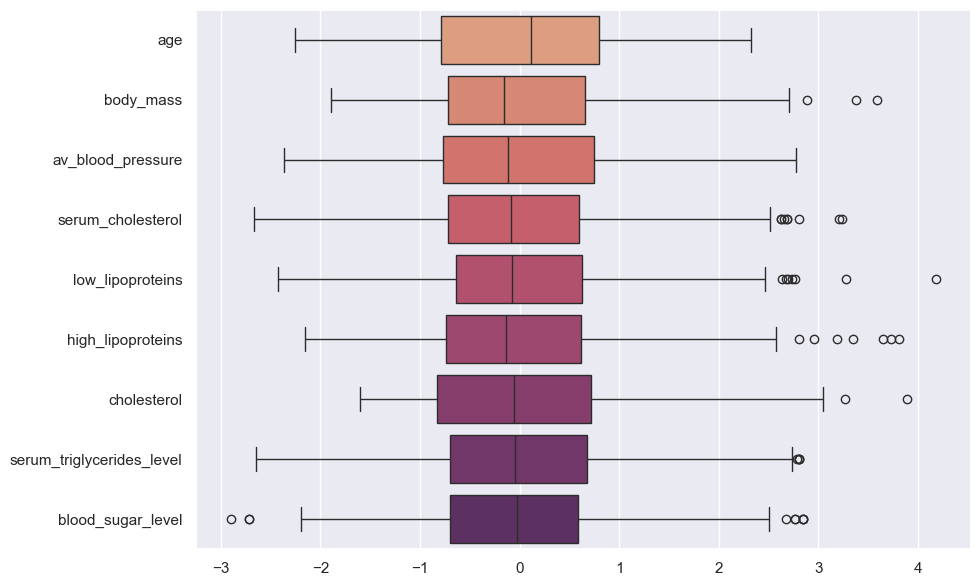

In [9]:
# il dataset viene standardizzato per migliorare la visualizzazione grafica del boxplot
features = df_diab.drop(columns=['diab_rate','sex'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
df_diab_scaled = pd.DataFrame(features_scaled, columns=features.columns)

# visualizzazione grafica degli outliers con boxplot
plt.figure(figsize=(10,7))
sns.boxplot(df_diab_scaled,orient='h',palette='flare')

<p>&nbsp;</p>

### Data la natura asimmetrica della distribuzione di frequenza dei valori della variabile target "diab_rate" e la natura simmetrica simile alla curva gaussiana nella distribuzione dei valori della maggior parte delle features, i modelli scelti nella fase di Model Selection saranno parametrici (_Linear Regression_, _Ridge_) e non (_Gradient Boosting Regressor_), seguendo un approccio empirico per comprendere quale delle due tipologie gestisce in maniera ottimale il dataset o se l'unione tra di esse, attraverso un modello ensemble,  possa riscontrare risultati migliori. 
### Inoltre verrà considerato particolarmente il modello SVR, data la sua capacità di rientrare attraverso il "kernel trick" sia nei modelli catalogati come parametrici che non.

***

## Pipeline & Baseline Model

A questo punto il dataset può essere diviso in training e test set.

Verrà creata una pipeline iniziale per stabilire un punto di partenza nella selezione dei modelli e la gestione del dataset rispetto a:

- la standardizzazione delle features attraverso la funzione __StandardScaler()__, in quanto esse presentano unità di misura differenti tra di loro
- l'impostazione di un modello __baseline__ (Linear Regression) per verificare la progressione delle capacità predittive con altri modelli, basandosi su dei punteggi introduttivi dell'indice R2 e del Mean Absolute Error

In [10]:
# divisione del dataset in training e test set
X, y = df_diab.iloc[:,1:].values, df_diab.iloc[:,0].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,shuffle=False)

<p>&nbsp;</p>


Model : LinearRegression()

R2 Score : 0.544
R2 for Over-Fitting : 0.509
MAE : 42.548


,features,features_weight
8,serum_triglycerides_level,29.707238
2,body_mass,23.757599
3,av_blood_pressure,13.938172
5,low_lipoproteins,10.087192
7,cholesterol,7.182331
9,blood_sugar_level,4.080254
0,age,-0.391039
6,high_lipoproteins,-1.635391
1,sex,-11.835137
4,serum_cholesterol,-22.455043


Text(0, 0.5, 'Valori Predetti')

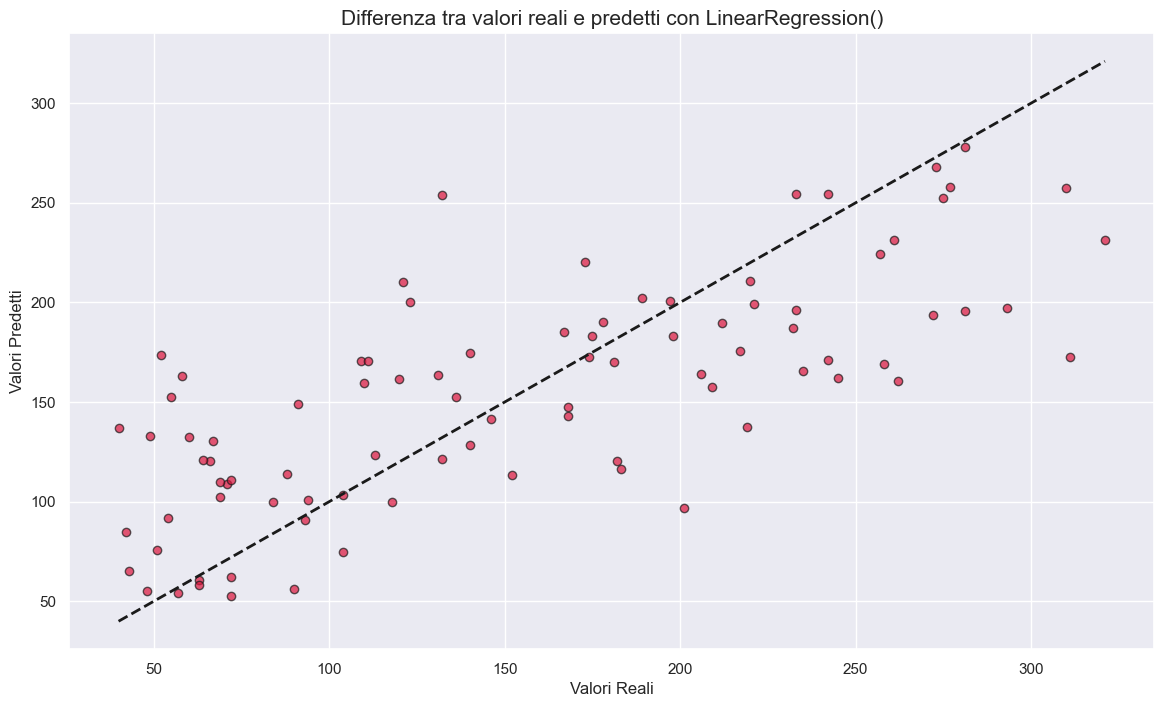

In [11]:
# creazione della pipeline base con scaler e modello baseline
base_pipeline = Pipeline([('scaler',StandardScaler()),('model',LinearRegression())])

# addestramento della pipeline e predizione sul test set
base_pipeline.fit(Xtrain,ytrain)
base_prediction = base_pipeline.predict(Xtest)

# visualizzazione dei risultati e dell'importanza delle variabili sulle predizioni
print(f"\nModel : {base_pipeline['model']}\n")
print(f'R2 Score : {base_pipeline.score(Xtest,ytest):.3f}')
print(f'R2 for Over-Fitting : {base_pipeline.score(Xtrain,ytrain):.3f}')
print(f'MAE : {MAE(ytest,base_prediction):.3f}')
display(pd.DataFrame({'features':df_diab.iloc[:,1:].columns,
                      'features_weight':base_pipeline['model'].coef_}).sort_values(by='features_weight',ascending=False))

# scatterplot per mostrare i valori reali in confronto ai valori predetti
plt.figure(figsize=(14,8))
plt.scatter(ytest, base_prediction, color='crimson', alpha=0.7, edgecolor='k')

# linea che rappresenta l'uguaglianza tra le predizioni ed i valori reali
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', lw=2)

# set estetico del grafico
plt.title(f"Differenza tra valori reali e predetti con {base_pipeline['model']}",fontsize=15)
plt.xlabel("Valori Reali")
plt.ylabel("Valori Predetti")

## Empirical Model Selection

Per questa fase iniziale di controllo delle performance, verrà impostata una pipeline base per scalare i valori delle features e testare i modelli.

In [12]:
# funzione per l'impostazione, l'addestramento e la visualizzazione dei risultati della pipeline in base al modello scelto
def selection_pipeline(model,features_train,features_test,color):
    
# impostazione della pipeline rispetto al modello scelto    
    pipeline = Pipeline([('scaler',StandardScaler()),('model',model)])
    
# addestramento della pipeline    
    pipeline.fit(features_train,ytrain)
    prediction = pipeline.predict(features_test)
    R2_score = pipeline.score(features_test,ytest)
    R2_OverFit = pipeline.score(features_train,ytrain)
    mae = MAE(ytest,prediction)
    
# visualizzazione dei risultati ottenuti
    print(f"\nModel : {model}\n")
    print(f'R2 Score : {R2_score:.3f}')
    print(f'R2 for Over-Fitting : { R2_OverFit:.3f}')
    print(f'MAE : {mae:.3f}')

# scatterplot per mostrare i valori reali in confronto ai valori predetti
    plt.figure(figsize=(14,8))
    plt.scatter(ytest, prediction, color=color, alpha=0.7, edgecolor='k')

    # linea che rappresenta l'uguaglianza tra le predizioni ed i valori reali
    plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', lw=2)

    # set estetico del grafico
    plt.title(f"Differenza tra valori reali e predetti con {model}",fontsize=15)
    plt.xlabel("Valori Reali")
    plt.ylabel("Valori Predetti")
    plt.show()
    

<p>&nbsp;</p>

### Parametric Models

I modelli parametrici scelti in base all'analisi esplorativa sono: 

- la __Ridge Linear Regression__, per ridurre l'impatto del basso numero di Outliers presenti e garantire maggior robustezza nella regolarizzazione rispetto al modello Lasso Linear Regression
- il __Support Vector Regressor__ con kernel lineare.


Model : Ridge()

R2 Score : 0.541
R2 for Over-Fitting : 0.509
MAE : 42.656


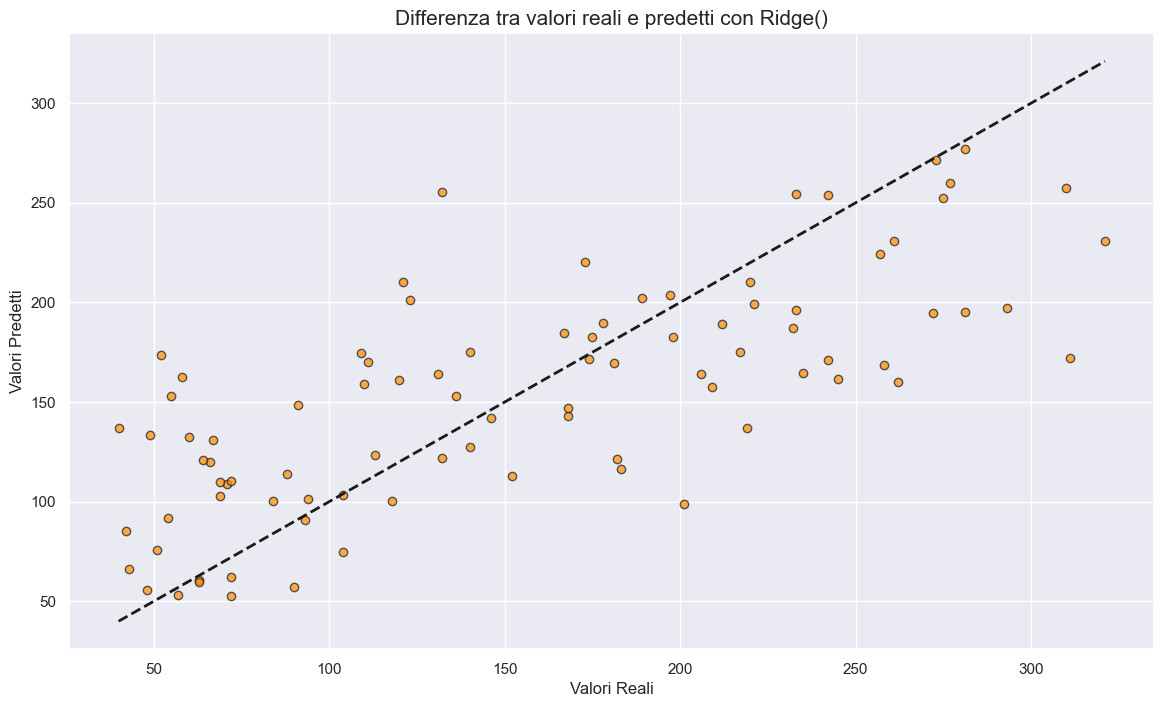


Model : SVR(kernel='linear')

R2 Score : 0.524
R2 for Over-Fitting : 0.499
MAE : 43.673


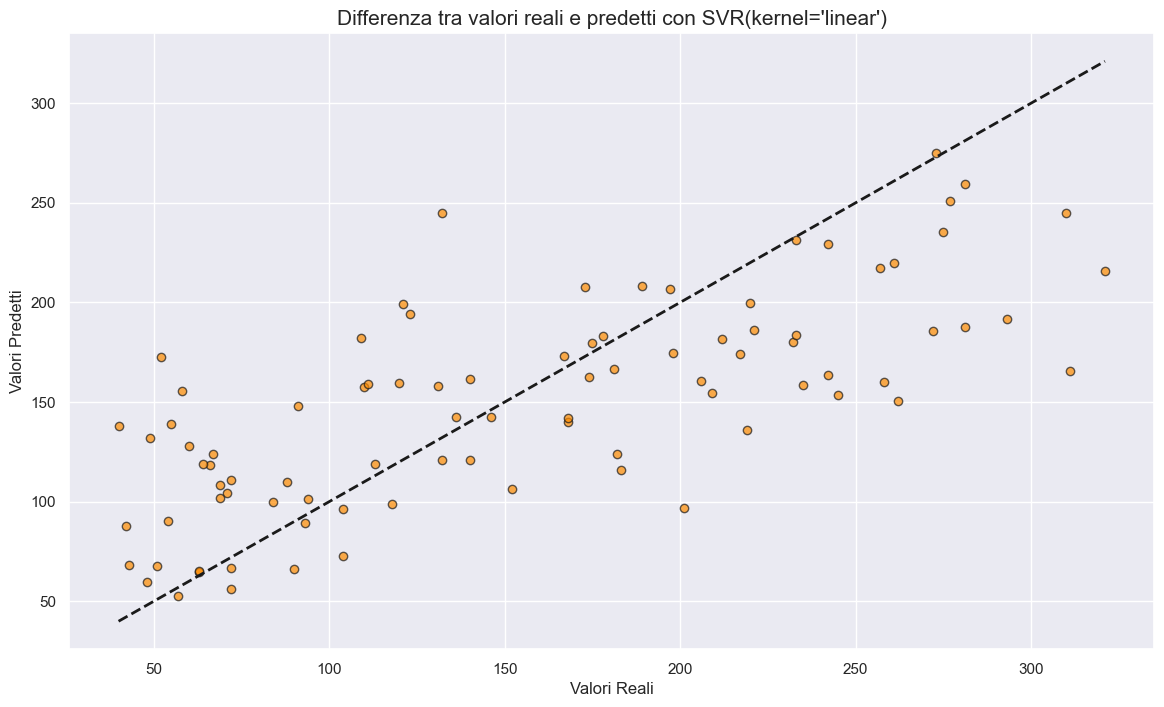

In [13]:
# addestramento e risultati per i modelli Ridge e SVR
selection_pipeline(Ridge(),Xtrain,Xtest,'darkorange')
selection_pipeline(SVR(kernel='linear'),Xtrain,Xtest,'darkorange')

<p>&nbsp;</p>

### Non-parametric Models

I modelli non parametrici scelti sono:

- il __Gradient Boosting Regressor__ per la sua minor sensibilità agli outlier rispetto a modelli come la regressione lineare, costruendo alberi sequenzialmente, migliorando le prestazioni incrementali e per cogliere relazioni non lineari, come quelle dimostrate dalla variabile 'sex' e per la sua migliore adattabilità a dataset di dimensione ridotta.

- il __Support Vector Regressor__ con kernel impostato sulla funzione in base radiale e sigmoide


Model : GradientBoostingRegressor()

R2 Score : 0.394
R2 for Over-Fitting : 0.836
MAE : 50.718


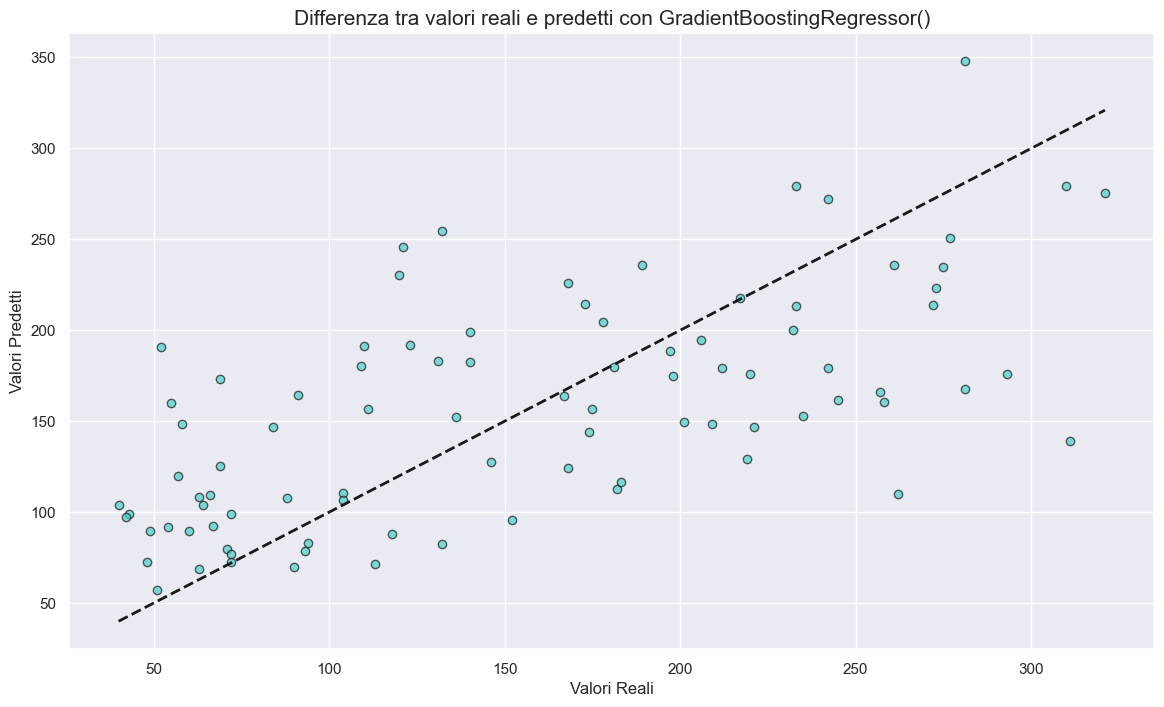


Model : SVR(kernel='sigmoid')

R2 Score : 0.365
R2 for Over-Fitting : 0.356
MAE : 54.192


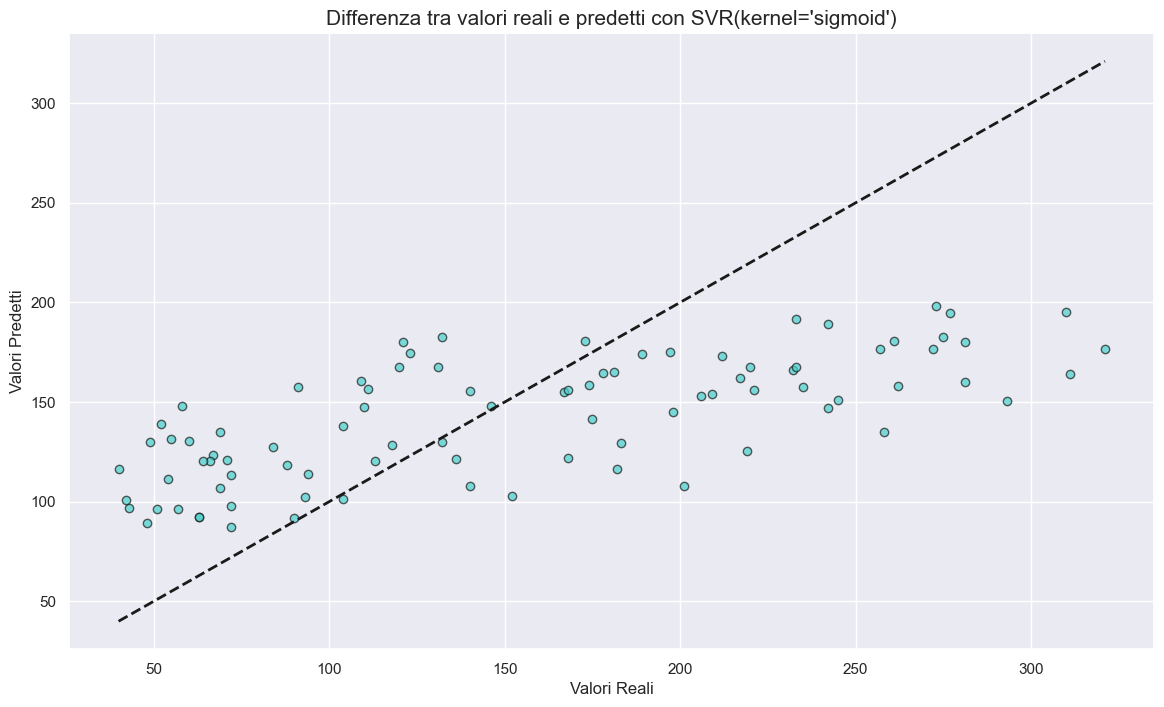


Model : SVR()

R2 Score : 0.160
R2 for Over-Fitting : 0.166
MAE : 62.784


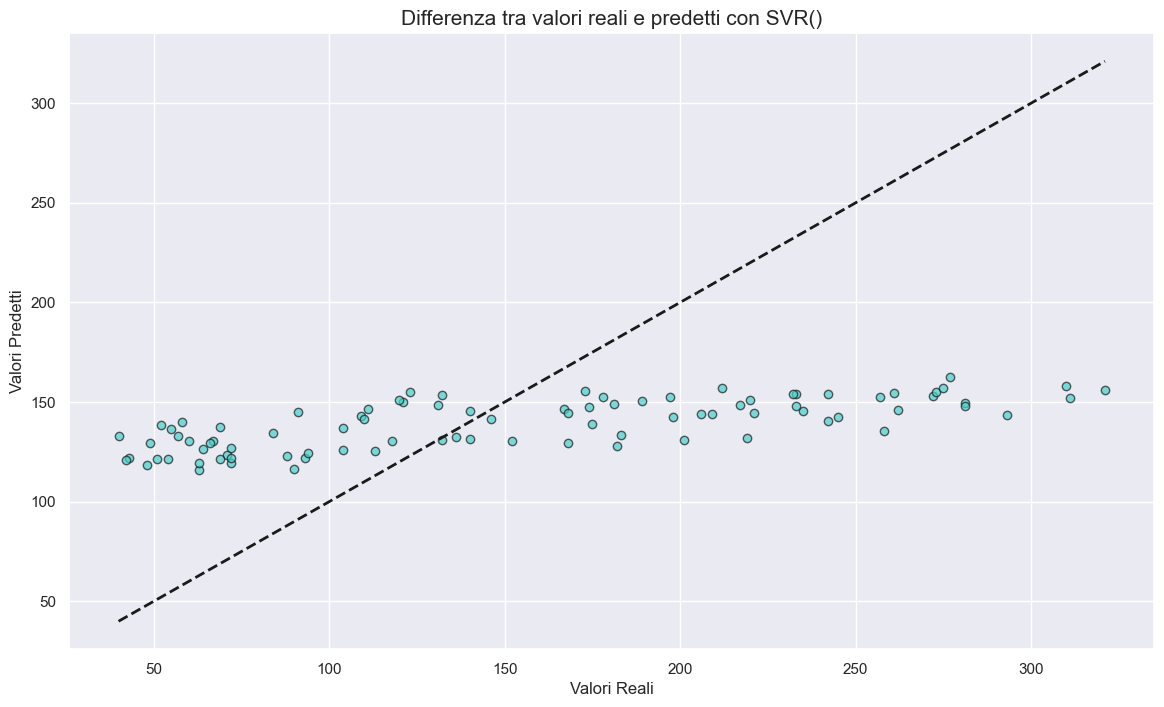

In [14]:
# addestramento e risultati per i modelli Ridge e SVR
selection_pipeline(GradientBoostingRegressor(),Xtrain,Xtest,'mediumturquoise')
selection_pipeline(SVR(kernel='sigmoid'),Xtrain,Xtest,'mediumturquoise')
selection_pipeline(SVR(kernel='rbf'),Xtrain,Xtest,'mediumturquoise')

<p>&nbsp;</p>

### I primi test empirici hanno dimostrato una maggiore adattabilità dei modelli di tipo parametrico rispetto al dataset in esame; per verificare ulteriormente questa rilevazione, si procederà con un approccio che integra features selection e hyperparameters tuning parallelamente per ottimizzare le capacità predittive e migliorare le performance rispetto al modello baseline.

***

## Features Selection & Hyperparameters Tuning

Per questa fase verrà utilizzata una funzione più complessa, che integri la features selection con l'hyperparameters tuning e riporti i risultati ottenuti con le features più adatte e gli iperparametri migliori riscontrati nell'addestramento per modelli parametrici e non.

<p>&nbsp;</p>

### Parametric Models

Data la differente importanza delle features e le differenti interazioni presenti tra di esse e la variabile target, si procederà alla __features selection__ con la __Recursive Features Elimination__ (__RFE__), in quanto questa modalità rimuove iterativamente le features meno importanti in base al modello utilizzato, selezionando in modo più efficiente il set di variabili migliori in base alla relazione con il modello stesso.

Rispetto all'__hyperparameters tuning__, gli iperparametri dei due modelli di tipo parametrico sono continui, di conseguenza la loro validazione sarà svolta attraverso la __RandomizedSearchCV__.

In [15]:
# funzione per la features selection e la cross-validation dei modelli parametrici selezionati
def parametric_model_validation(model,n_features,params):
    
# pipeline per la selezione delle feature migliori in base alla quantità di features selezionate
    pipeline = Pipeline([('scaler',StandardScaler()),('selector',RFE(model,n_features_to_select=n_features, step=1))])
    pipeline.fit(Xtrain,ytrain)

# isolamento degli indici e dei nomi delle features raccolte
    rfe_features = pipeline['selector'].get_support(indices=True)
    rfe_features_names = df_diab.drop(columns='diab_rate').iloc[:,rfe_features].columns

# aggiornamento del training e test set con feature selezionate da RFE
    Xtrain_rfe = Xtrain[:,rfe_features]
    Xtest_rfe = Xtest[:,rfe_features]

# cross-validation del modello selezionato con i nuovi set creati in base alle scelte di RFE
    grid = RandomizedSearchCV(model,params,cv=5,n_iter=10,n_jobs=-1,scoring='r2',random_state=10)
    grid.fit(Xtrain_rfe,ytrain)

# selezione del modello con i parametri migliori e predizioni
    best = grid.best_estimator_
    prediction = best.predict(Xtest_rfe)

# variabili con i punteggi ottenuti dal modello migliore
    r2 = round(best.score(Xtest_rfe,ytest),3)
    overfit = round(best.score(Xtrain_rfe,ytrain),3)
    mae = round(MAE(ytest,prediction),3)

# visualizzazione dei risultati attraverso un dizionario
    return {'Model': best,
            'Number of Features': n_features,
            'Features': list(rfe_features_names),
            'R2 Score':r2,
            'Over-Fitting':overfit,
            'MAE':mae}  

Si osserva un leggero miglioramento rispetto ai modelli iniziali, sufficiente solo nel caso del modello Ridge Linear Regression a superare il punteggio R2 ottenuto dal modello baseline:

<p>&nbsp;</p>

- __Ridge__ : 
    - indice R2 da 0.541 a 0.55
    - Mean Absolute Error da 42.656 a 42.643

<p>&nbsp;</p>
    
- __SVR (kernel = 'linear')__ : 
    - indice R2 da 0.524 a 0.532
    - Mean Absolute Error da 43.673 a 43.243

In [16]:
# liste che conterranno i risultati ottenuti per ogni set di features selezionato attraverso RFE
result_ridge = []
result_svr = []

# iperparametri impostati per la cross-validation dei modelli parametrici selezionati
params_ridge = {'alpha':[0.0001,0.001,0.01,0.1,1,10,20,50,70,100]}
params_svr = {'C':[1,10,20,30,40],'epsilon':[0.1,1,3,5,10,100]}

# iterazione del numero di features selezionate per i set di training e test con RFE e cross-validation, per ogni set con
# la funzione parametric_model_validation
for n in range(1,Xtrain.shape[1]+1):
    result_ridge.append(parametric_model_validation(Ridge(),n,params_ridge))
    result_svr.append(parametric_model_validation(SVR(kernel='linear'),n,params_svr))
    
#  visualizzazione dei risultati migliori ottenuti attravero un Data Frame ordinato per i valori maggiori di R2 
df_results_ridge = pd.DataFrame(result_ridge).sort_values(by='R2 Score',ascending=False)
display(df_results_ridge)

df_results_svr = pd.DataFrame(result_svr).sort_values(by='R2 Score',ascending=False)
display(df_results_svr)


,Model,Number of Features,Features,R2 Score,Over-Fitting,MAE
5,Ridge(alpha=1),6,"[sex, body_mass, av_blood_pressure, serum_chol...",0.550,0.504,42.643
6,Ridge(alpha=1),7,"[sex, body_mass, av_blood_pressure, serum_chol...",0.546,0.507,42.660
7,Ridge(alpha=0.1),8,"[sex, body_mass, av_blood_pressure, serum_chol...",0.545,0.507,42.615
8,Ridge(alpha=1),9,"[sex, body_mass, av_blood_pressure, serum_chol...",0.541,0.509,42.693
9,Ridge(alpha=1),10,"[age, sex, body_mass, av_blood_pressure, serum...",0.541,0.509,42.694
4,Ridge(alpha=1),5,"[body_mass, av_blood_pressure, serum_cholester...",0.534,0.488,43.887
3,Ridge(alpha=1),4,"[body_mass, serum_cholesterol, low_lipoprotein...",0.497,0.470,46.035
2,Ridge(alpha=1),3,"[body_mass, serum_cholesterol, serum_triglycer...",0.486,0.465,46.638
1,Ridge(alpha=1),2,"[body_mass, serum_triglycerides_level]",0.473,0.455,48.161
0,Ridge(alpha=100),1,[body_mass],0.365,0.338,53.895


,Model,Number of Features,Features,R2 Score,Over-Fitting,MAE
5,"SVR(C=30, epsilon=5, kernel='linear')",6,"[sex, body_mass, av_blood_pressure, low_lipopr...",0.532,0.501,43.243
4,"SVR(C=20, epsilon=1, kernel='linear')",5,"[sex, body_mass, av_blood_pressure, high_lipop...",0.528,0.496,43.376
7,"SVR(C=30, epsilon=3, kernel='linear')",8,"[sex, body_mass, av_blood_pressure, low_lipopr...",0.527,0.501,43.303
8,"SVR(C=30, epsilon=3, kernel='linear')",9,"[sex, body_mass, av_blood_pressure, serum_chol...",0.524,0.501,43.463
6,"SVR(C=1, epsilon=1, kernel='linear')",7,"[sex, body_mass, av_blood_pressure, low_lipopr...",0.523,0.483,44.433
9,"SVR(C=20, kernel='linear')",10,"[age, sex, body_mass, av_blood_pressure, serum...",0.523,0.502,43.613
3,"SVR(C=20, kernel='linear')",4,"[body_mass, av_blood_pressure, high_lipoprotei...",0.519,0.478,45.495
2,"SVR(C=10, epsilon=1, kernel='linear')",3,"[body_mass, av_blood_pressure, serum_triglycer...",0.510,0.465,46.620
1,"SVR(C=20, epsilon=1, kernel='linear')",2,"[body_mass, serum_triglycerides_level]",0.469,0.448,47.768
0,"SVR(C=1, epsilon=5, kernel='linear')",1,[body_mass],0.348,0.325,53.393


<p>&nbsp;</p>

### Non-parametric Models

Data la maggiore complessità dei modelli non parametrici, si procederà alla __features selection__ con la __Permutation Importance__, in quanto essa non richiede l'accesso diretto ai parametri come la RFE, valutando l'importanza delle variabili in base alle performance predittive del modello utilizzato e rimanendo quindi generalmente più robusta con i modelli con alta complessità computazionale.

Il metodo utilizzato per l'hyperparameters tuning sarà anche questa volta la __RandomizedSearchCV__, data la maggiore quantità di iperparametri e di valori da testare per gli stessi nei modelli non parametrici selezionati.

In [17]:
# funzione per la features selection e la cross-validation dei modelli non parametrici selezionati
def non_parametric_model_validation(model,params):

# pipeline per la standardizzazione delle features e l'impostazione del modello
    pipeline = Pipeline([('scaler',StandardScaler()),('model',model)])
    pipeline.fit(Xtrain,ytrain)
    
# variabile che racchiude l'importanza media delle variabili secondo la permutation importance   
    importances = permutation_importance(pipeline, Xtest, ytest, n_repeats=10, random_state=10)['importances_mean']
    features_importance = pd.DataFrame({'features':df_diab.iloc[:,1:].columns,
                                        'importance':importances}).sort_values(by='importance',ascending=False).reset_index()

# lista che raccoglie gli indici delle features ordinato rispetto all'importanza riscontrata nella permutation importance
    permutation_features_idx = []

# liste che raccologono i risultati dell'addestramento del modello rispetto ai differenti set di features combinati in base
# all'importanza riscontrata dalle variabili
    features_set = []
    Model = []
    Hyperparameters = []
    R2_Score = []
    Over_Fitting = []
    MAE_Score = []

# loop sul numero delle features, il loro indice di posizione nel train e test set e la loro denominazione
    for n,[index,feature] in enumerate(features_importance[['index','features']].values,1):

# gli indici sono inseriti nella lista creata in precedenza per importanza in ordine decrescente
        permutation_features_idx.append(index)

# il train e test set vengono modificati in base agli indici inseriti man mano nella lista 
        Xtrain_perm = Xtrain[:,permutation_features_idx]
        Xtest_perm = Xtest[:,permutation_features_idx]

# il modello viene addestrato e testato con la cross-validation su ogni set di features nell'iterazione
        grid = RandomizedSearchCV(pipeline, params, cv=5, n_iter=10, n_jobs=-1, scoring='r2', random_state=10)
        grid.fit(Xtrain_perm,ytrain)
        best = grid.best_estimator_
        prediction = best.predict(Xtest_perm)

# i risulati sono raccolti nelle liste organizzate precedentemente
        features_set.append(list(features_importance.iloc[:n,1]))
        Model.append(f'{model}')
        Hyperparameters.append(grid.best_params_)
        R2_Score.append(round(best.score(Xtest_perm,ytest),3))
        Over_Fitting.append(round(best.score(Xtrain_perm,ytrain),3))
        MAE_Score.append(round(MAE(ytest,prediction),3))

# la funzione riporta un Data Frame che raccoglie tutti i risultati riscontrati dai vari set di features
    return pd.DataFrame({'Model': Model,
                         'Best Parameters': Hyperparameters,
                         'Features Set': features_set,
                         'R2 Score':R2_Score,
                         'Over-Fitting':Over_Fitting,
                         'MAE':MAE_Score}).sort_values(by='R2 Score',ascending=False)                    

Si osserva un miglioramento significativo rispetto ai modelli iniziali, non ancora sufficiente a sostenere le performance dimostrate dal modello baseline:

<p>&nbsp;</p>

- __Gradient Boosting Regressor__ : 
    - indice R2 da 0.395 a 0.507
    - Over-Fitting da 0.836 a 0.605
    - Mean Absolute Error da 50.693 a 44.790

<p>&nbsp;</p>
    
- __SVR (kernel = 'sigmoid')__ : 
    - indice R2 da 0.365 a 0.525
    - Mean Absolute Error da 54.192 a 43.527

<p>&nbsp;</p>
    
- __SVR (kernel = 'rbf')__ : 
    - indice R2 da 0.160 a 0.538
    - Mean Absolute Error da 62.784 a 43.777

In [18]:
#parametri per l'hyperparameters tuning dei modelli non parametrici selezionati
params_gbr = {'model__learning_rate':[0.001,0.01,0.1,1],
              'model__n_estimators':[100,300,500,700],
              'model__max_depth':[2,5,10,15,20,30],
              'model__min_samples_leaf':[10,50,100,150],
              'model__min_samples_split':[2,5,10,20,50,70]}

params_svr_s = {'model__C':[0.1,1,10,20,30,50],
                'model__epsilon':[0.1,1,3,5,7,10,20]}

params_svr_r = {'model__C':[0.1,1,10,20,30,50],
                'model__epsilon':[0.1,1,10,20,30,50]}

# visualizzazione dei risultati in base alla funzione "non_parametric_model_validation" con permutation importance e cross-validation
display(non_parametric_model_validation(GradientBoostingRegressor(),params_gbr))
display(non_parametric_model_validation(SVR(kernel='sigmoid'),params_svr_s))
display(non_parametric_model_validation(SVR(kernel='rbf'),params_svr_r))

,Model,Best Parameters,Features Set,R2 Score,Over-Fitting,MAE
6,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.507,0.625,44.790
5,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.506,0.605,44.422
4,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.504,0.595,44.951
7,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.496,0.637,45.031
8,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.496,0.637,45.031
3,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.491,0.571,45.936
9,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.487,0.638,45.208
2,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level, av_bloo...",0.471,0.548,46.668
1,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...","[body_mass, serum_triglycerides_level]",0.428,0.512,48.331
0,GradientBoostingRegressor(),"{'model__n_estimators': 100, 'model__min_sampl...",[body_mass],0.340,0.363,53.896


,Model,Best Parameters,Features Set,R2 Score,Over-Fitting,MAE
9,SVR(kernel='sigmoid'),"{'model__epsilon': 20, 'model__C': 10}","[body_mass, serum_triglycerides_level, av_bloo...",0.525,0.456,43.527
8,SVR(kernel='sigmoid'),"{'model__epsilon': 20, 'model__C': 10}","[body_mass, serum_triglycerides_level, av_bloo...",0.514,0.430,43.655
7,SVR(kernel='sigmoid'),"{'model__epsilon': 20, 'model__C': 10}","[body_mass, serum_triglycerides_level, av_bloo...",0.473,0.367,46.283
2,SVR(kernel='sigmoid'),"{'model__epsilon': 0.1, 'model__C': 1}","[body_mass, serum_triglycerides_level, av_bloo...",0.454,0.416,49.791
1,SVR(kernel='sigmoid'),"{'model__epsilon': 0.1, 'model__C': 1}","[body_mass, serum_triglycerides_level]",0.444,0.409,50.094
3,SVR(kernel='sigmoid'),"{'model__epsilon': 0.1, 'model__C': 1}","[body_mass, serum_triglycerides_level, av_bloo...",0.434,0.401,50.274
4,SVR(kernel='sigmoid'),"{'model__epsilon': 0.1, 'model__C': 1}","[body_mass, serum_triglycerides_level, av_bloo...",0.428,0.391,50.542
5,SVR(kernel='sigmoid'),"{'model__epsilon': 0.1, 'model__C': 1}","[body_mass, serum_triglycerides_level, av_bloo...",0.421,0.385,51.151
6,SVR(kernel='sigmoid'),"{'model__epsilon': 0.1, 'model__C': 1}","[body_mass, serum_triglycerides_level, av_bloo...",0.414,0.384,51.840
0,SVR(kernel='sigmoid'),"{'model__epsilon': 0.1, 'model__C': 1}",[body_mass],0.311,0.275,56.162


,Model,Best Parameters,Features Set,R2 Score,Over-Fitting,MAE
4,SVR(),"{'model__epsilon': 0.1, 'model__C': 20}","[body_mass, serum_triglycerides_level, av_bloo...",0.538,0.491,43.777
9,SVR(),"{'model__epsilon': 0.1, 'model__C': 20}","[body_mass, serum_triglycerides_level, av_bloo...",0.535,0.566,44.067
5,SVR(),"{'model__epsilon': 10, 'model__C': 50}","[body_mass, serum_triglycerides_level, av_bloo...",0.522,0.559,45.245
3,SVR(),"{'model__epsilon': 0.1, 'model__C': 20}","[body_mass, serum_triglycerides_level, av_bloo...",0.521,0.478,44.316
2,SVR(),"{'model__epsilon': 0.1, 'model__C': 20}","[body_mass, serum_triglycerides_level, av_bloo...",0.516,0.479,44.973
8,SVR(),"{'model__epsilon': 0.1, 'model__C': 20}","[body_mass, serum_triglycerides_level, av_bloo...",0.504,0.536,46.567
7,SVR(),"{'model__epsilon': 10, 'model__C': 50}","[body_mass, serum_triglycerides_level, av_bloo...",0.501,0.570,46.272
6,SVR(),"{'model__epsilon': 10, 'model__C': 50}","[body_mass, serum_triglycerides_level, av_bloo...",0.500,0.569,46.542
1,SVR(),"{'model__epsilon': 0.1, 'model__C': 20}","[body_mass, serum_triglycerides_level]",0.478,0.467,46.103
0,SVR(),"{'model__epsilon': 1, 'model__C': 50}",[body_mass],0.365,0.323,50.849


<p>&nbsp;</p>

In definitiva i migliori modelli ottenuti per entrambe le tipologie sono:

- __Ridge Linear Regression__ con:

    - __Hyperparameters__:
        - _alpha = 1_
     
    - __Features Set__: 
        - "_sex_"
        - "_body_mass_"
        - "_av_blood_pressure_"
        - "_serum_cholesterol_"
        - "_low_lipoproteins_"
        - "_serum_trglycerides_level_"

<p>&nbsp;</p>

- __Support Vector Regressor (kernel='rbf')__ con:

    - __Hyperparameters__:
        - _C = 20_
        - _epsilon = 0.1_
    
    - __Features Set__:
        - "_body_mass_"
        - "_serum_trglycerides_level_"
        - "_av_blood_pressure_"
        - "_cholesterol_"
        - "_high_lipoproteins_"


Model : Ridge(alpha=1)

R2 Score : 0.549
R2 for Over-Fitting : 0.504
MAE : 42.625


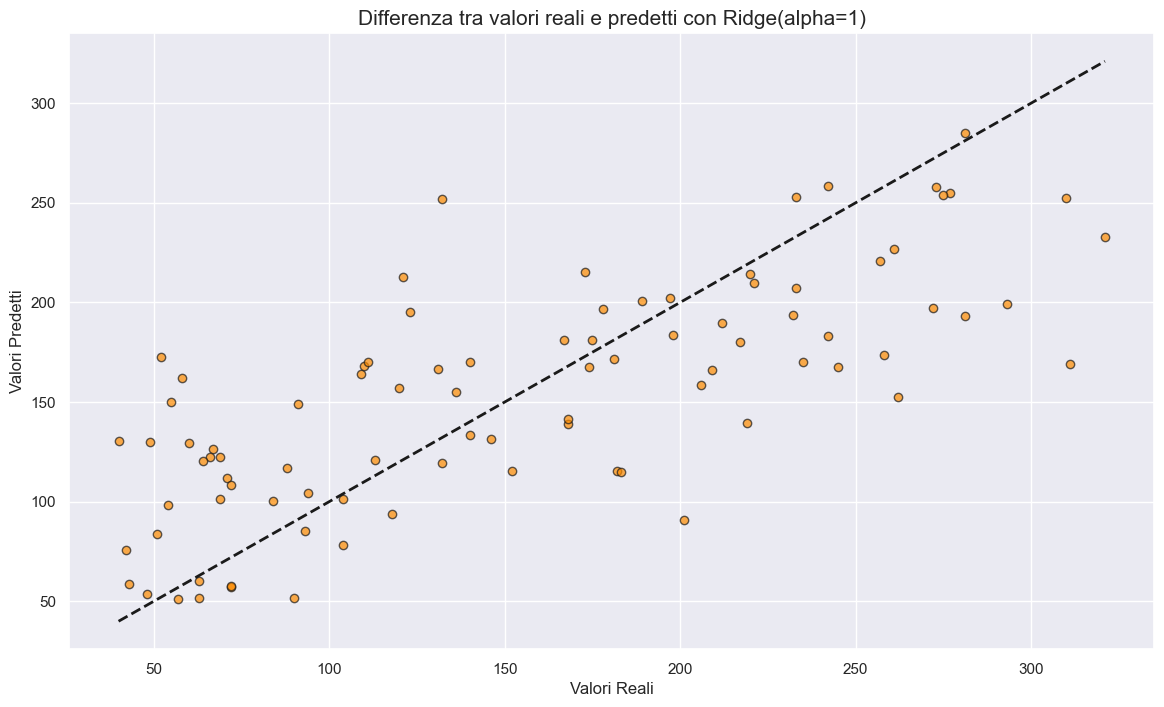


Model : SVR(C=20)

R2 Score : 0.538
R2 for Over-Fitting : 0.491
MAE : 43.777


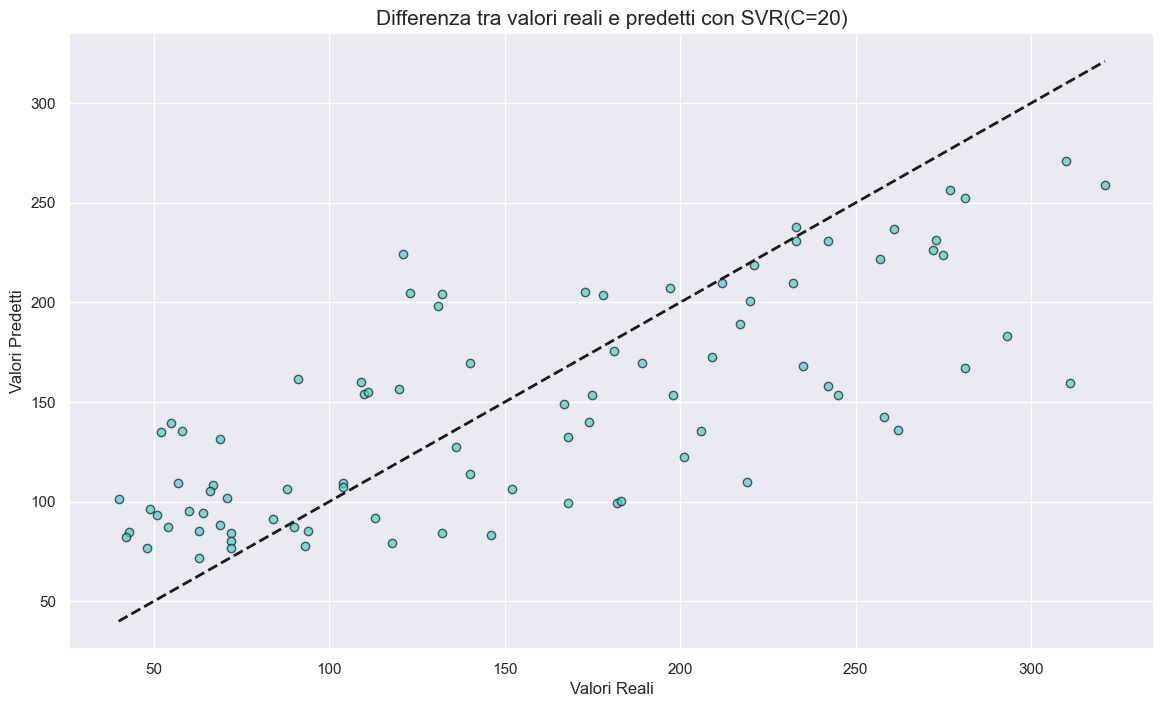

In [19]:
# features set selezionati con RFE e permutation importance precedentemente per i migliori modelli Ridge e SVR (kernel='rbf')
ridge_fset = list(df_results_ridge['Features'].head(1))
svr_rbf_fset = list(non_parametric_model_validation(SVR(kernel='rbf'),params_svr_r)['Features Set'].head(1))

# estrazione degli indici delle features dal dataset originario per entrambi i set
ridge_fset_idx = [df_diab.drop(columns='diab_rate').columns.get_loc(name) for name in ridge_fset[0]]
svr_rbf_fset_idx = [df_diab.drop(columns='diab_rate').columns.get_loc(name) for name in svr_rbf_fset[0]]

# creazione dei training e test set di features in base agli indici estratti dai training e test set originari
Xtrain_ridge = Xtrain[:,ridge_fset_idx]
Xtest_ridge = Xtest[:,ridge_fset_idx]

Xtrain_svr = Xtrain[:,svr_rbf_fset_idx]
Xtest_svr = Xtest[:,svr_rbf_fset_idx]

# visualizzazione dei risultati dei modelli migliori per la tipologia parametrica e non con la funzione selection_pipeline
selection_pipeline(Ridge(alpha=1),Xtrain_ridge,Xtest_ridge,'darkorange')
selection_pipeline(SVR(kernel='rbf',C=20,epsilon=0.1),Xtrain_svr,Xtest_svr,'mediumturquoise')

<p>&nbsp;</p>

### Le performance riscontrate durante questo secondo test empirico mostrano in particolare un discreto miglioramento rispetto ai risultati ottenuti con il modello baseline per il punteggio dell'indice R2 attraverso l'utilizzo della Ridge Linear Regression, ma anche un miglioramento delle capacità predittive dei modelli non parametrici, in particolare con il modello Support Vector Regressor con kernel in base radiale , che mantiene un equilibrio migliore tra i risultati dell'indice di determinazione e l'Over-Fitting ottenuti su test e training set, dimostrando una capacità predittiva più attendibile sui nuovi dati.

### Di conseguenza l'ultimo test empirico cercherà di migliorare le performance del modello con regolarizzazione in base Ridge, creando un modello ensemble che possa assimilare le capacità predittive dimostrate dal modello migliore appartenente alla tipologia non parametrica, ossia il modello SVR con kernel in base radiale.

###

## Ensemble Voting Regressor

Con lo scopo di migliorare le prestazioni complessive dei due modelli individuati precedentemente, verrà creato un modello unico attraverso la tecnica ensemble del __Voting Regressor__, combinando le predizioni dei due metodi di regressione, parametrico e non, per ottenere con caratteristiche diverse una previsione unica basata sulla media ponderata delle previsioni individuali.

Il modello ensemble verrà poi testato con il training e test set base ed i training e test set di features isolati attraverso la RFE e la Permutation Importance per i modelli Ridge e SVR con kernel in base radiale, che compongono il modello ensemble stesso.

In [20]:
# variabili con i migliori modelli parametrici e non riscontrati
m1 = Ridge(alpha=1)
m2 = SVR(epsilon=0.1,C=20)

# creazione del modello ensemble basato sui due migliori modelli
ens_model = VotingRegressor([('Ridge',m1),('SVR_rbf',m2)])

<p>&nbsp;</p>

### Voting regressor con set di features iniziali

Il modello Voting Regressor addestrato con i training e test set iniziali mostra un significativo miglioramento rispetto al modello baseline nell'indice $R^2$ ed una discreta diminuzione dell'errore medio assoluto sulle previsioni.


Model : VotingRegressor(estimators=[('Ridge', Ridge(alpha=1)), ('SVR_rbf', SVR(C=20))])

R2 Score : 0.562
R2 for Over-Fitting : 0.557
MAE : 42.126


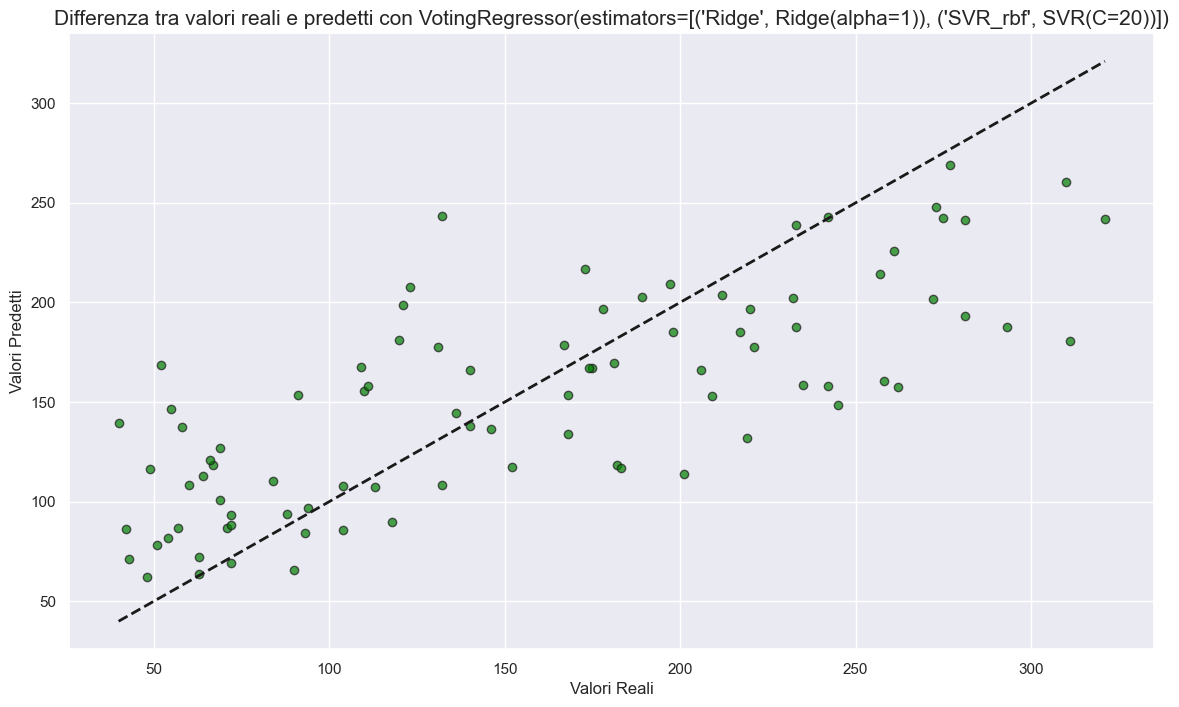

In [21]:
selection_pipeline(ens_model,Xtrain,Xtest,'green')

<p>&nbsp;</p>

### Voting Regressor con set di features selezionato da RFE per Ridge Linear Regression

Il modello Voting Regressor addestrato con i training e test set selezionati dalla RFE rispetto al modello Ridge migliora significativamente il punteggio dell'indice $R^2$ e riduce maggiormente l'errore medio assoluto sulle predizioni rispetto al modello baseline e agli altri test empirici svolti con il Voting Regressor.


Model : VotingRegressor(estimators=[('Ridge', Ridge(alpha=1)), ('SVR_rbf', SVR(C=20))])

R2 Score : 0.571
R2 for Over-Fitting : 0.534
MAE : 41.216


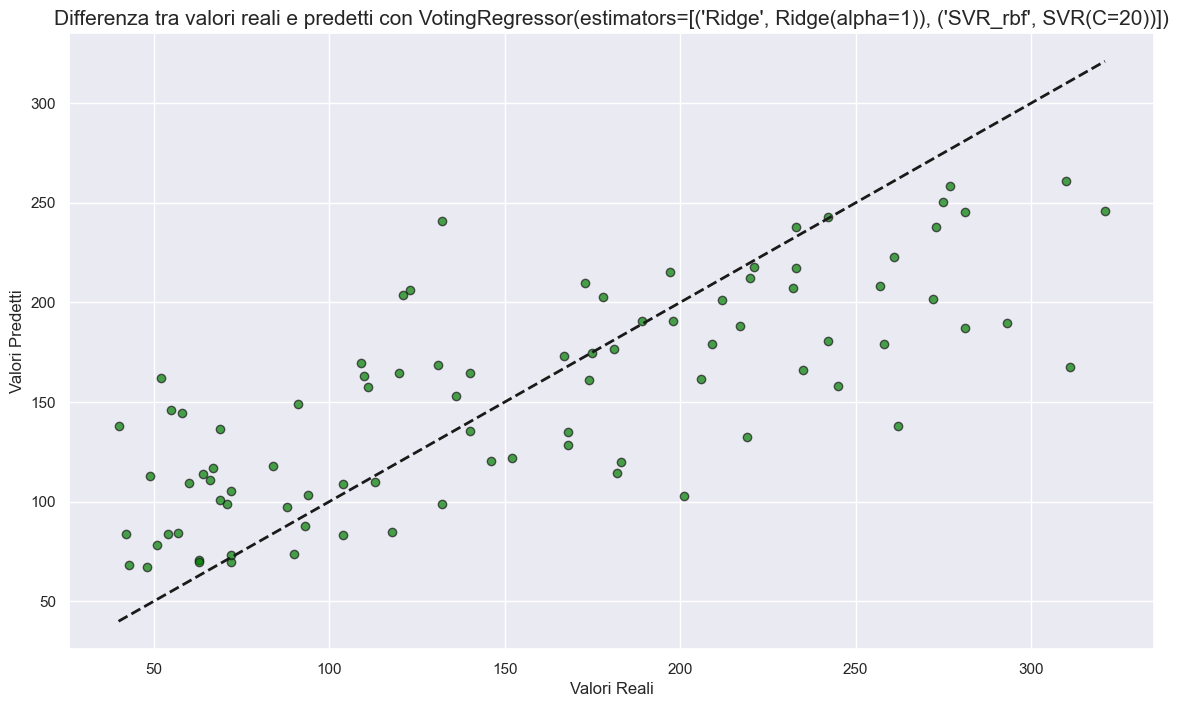

In [22]:
selection_pipeline(ens_model,Xtrain_ridge,Xtest_ridge,'green')

<p>&nbsp;</p>

### Voting Regressor con set di features selezionato da Permutation Importance per SVR in base radiale

Il modello Voting Regressor addestrato con i training e test set selezionati dalla Permutation Importance rispetto al modello SVR causa una diminuzione del punteggio dell'indice $R^2$ ed un aumento sull'erorre medio assoluto commesso sulle previsioni rispetto ai due scenari precedenti, riportando comunque un miglioramento rispetto al modello baseline.


Model : VotingRegressor(estimators=[('Ridge', Ridge(alpha=1)), ('SVR_rbf', SVR(C=20))])

R2 Score : 0.549
R2 for Over-Fitting : 0.504
MAE : 43.161


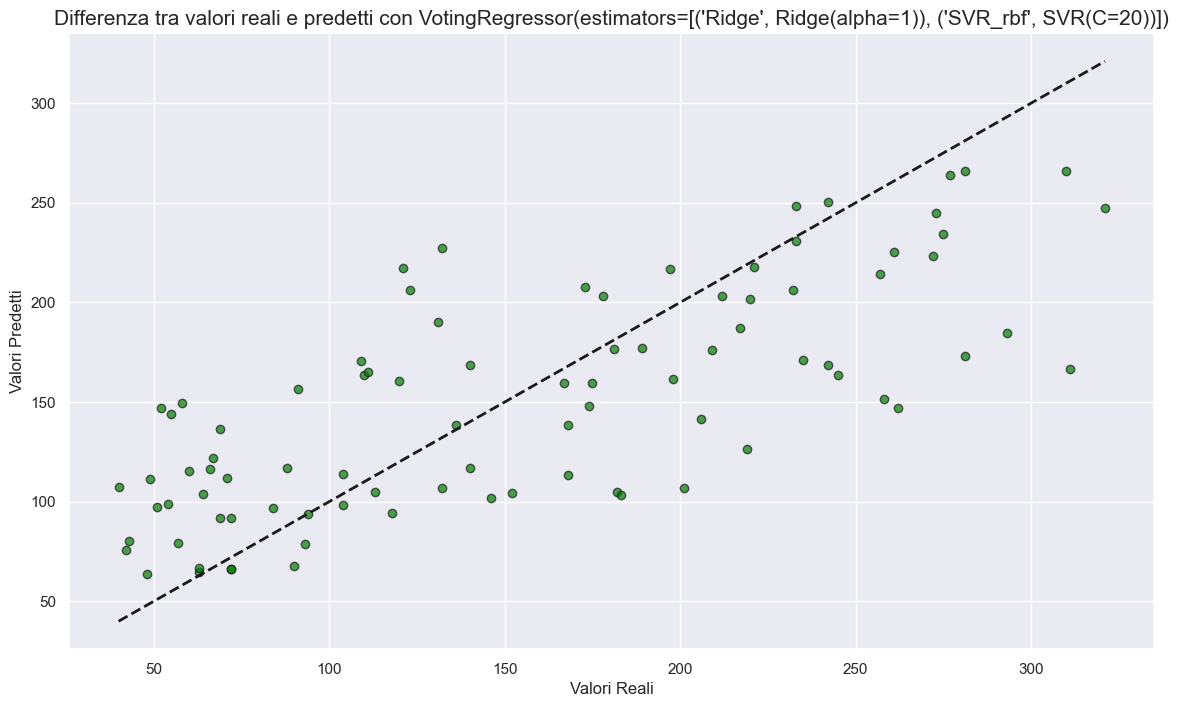

In [23]:
selection_pipeline(ens_model,Xtrain_svr,Xtest_svr,'green')

***

## Conclusioni

#### In definitiva, il modello migliore riscontrato per la previsione dell'indice di progressione del diabete è il Voting Regressor allenato con le features selezionate attraverso il metodo RFE applicato sul modello Ridge Linear Regression, migliorando le proprie capacità rispetto al modello baseline con:

- #### l'aumento del 3% del punteggio dell'indice $R^2$ (da 0.544 a 0.571) 
- #### la conservazione dell'equilibrio tra i risultati dell'indice $R2$ e l'Over-Fitting (da 0.544-0.509 a 0.571-0.534 )
- #### la riduzione del 3% dell'errore assoluto sulle predizioni MAE (da 42.548 a 41.216)


Model : VotingRegressor(estimators=[('Ridge', Ridge(alpha=1)), ('SVR_rbf', SVR(C=20))])

Features Set:
[['sex', 'body_mass', 'av_blood_pressure', 'serum_cholesterol', 'low_lipoproteins', 'serum_triglycerides_level']]

R2 Score : 0.571
R2 for Over-Fitting : 0.534
MAE : 41.216


Text(0, 0.5, 'Errore')

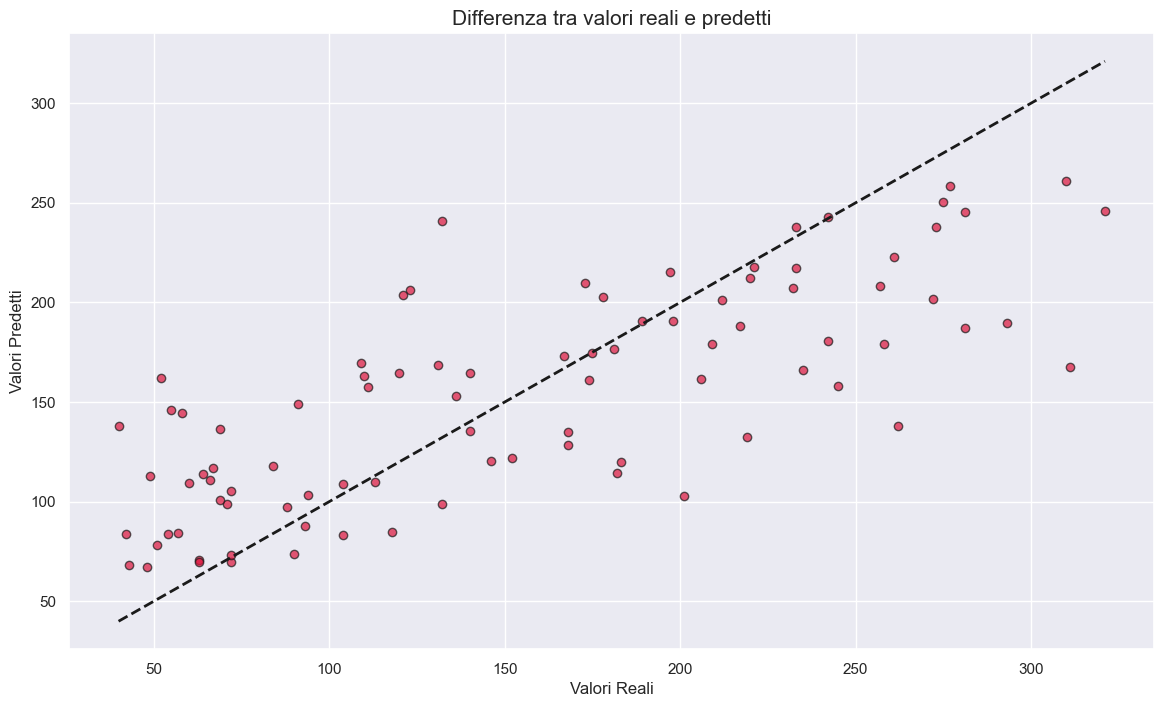

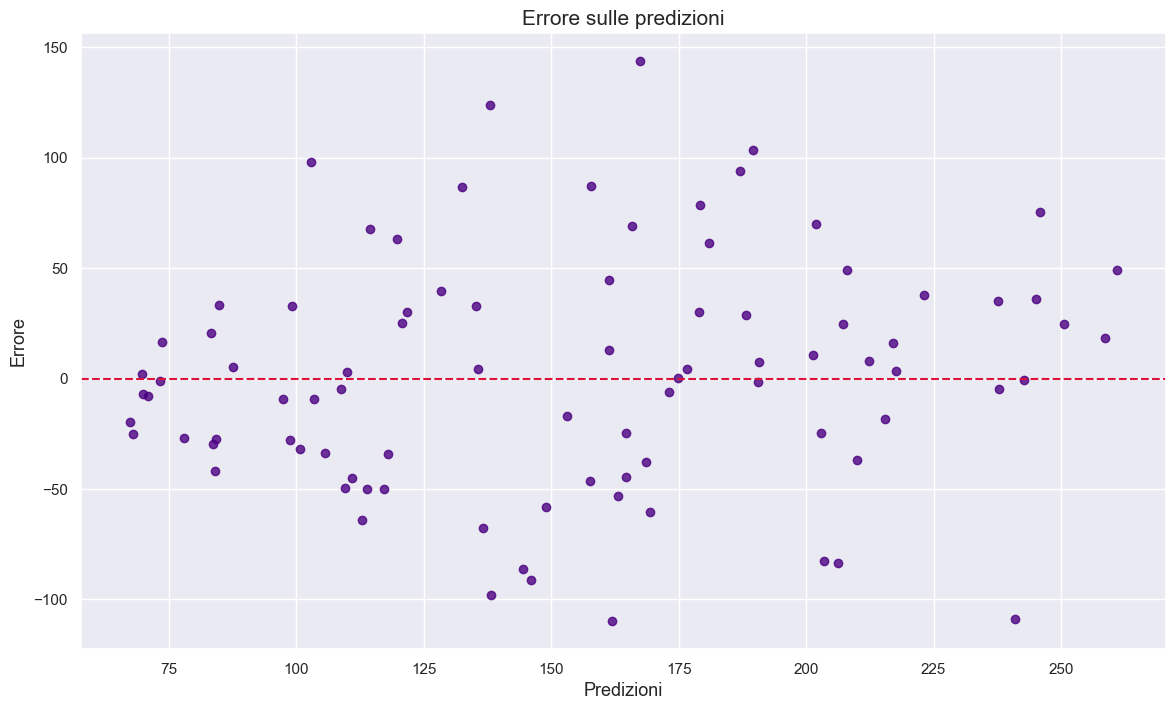

In [24]:
ensemble_pipeline = Pipeline([('scaler',StandardScaler()),('model',ens_model)])
ensemble_pipeline.fit(Xtrain_ridge,ytrain)

prediction = ensemble_pipeline.predict(Xtest_ridge)
r2 = round(ensemble_pipeline.score(Xtest_ridge,ytest),3)
overfit = round(ensemble_pipeline.score(Xtrain_ridge,ytrain),3)
mae = round(MAE(ytest,prediction),3)

print(f"\nModel : {ens_model}\n")
print(f'Features Set:\n{ridge_fset}\n')
print(f'R2 Score : {r2}')
print(f'R2 for Over-Fitting : {overfit}')
print(f'MAE : {mae}')

# scatterplot per mostrare i valori reali in confronto ai valori predetti
plt.figure(figsize=(14,8))
plt.scatter(ytest, prediction, color='crimson', alpha=0.7, edgecolor='k')

# linea che rappresenta l'uguaglianza tra le predizioni ed i valori reali
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', lw=2)

# set estetico del grafico
plt.title(f"Differenza tra valori reali e predetti",fontsize=15)
plt.xlabel("Valori Reali")
plt.ylabel("Valori Predetti")

# creazione dello scatter plot per mostrare il pattern degli errori sulle predizioni
plt.figure(figsize=(14,8))

# calcolo dei residui sulle predizioni
residuals = ytest - prediction

# punti rappresentanti gli errori sulle predizioni
plt.scatter(prediction, residuals, alpha=0.8, color = 'indigo')

# linea che rappresenta l'assenza di errore tra predizioni e valori reali
plt.axhline(0, color='crimson', linestyle='--')

# set estetico del grafico
plt.title('Errore sulle predizioni',fontsize=15)
plt.xlabel('Predizioni',fontsize=13)
plt.ylabel('Errore',fontsize=13)